<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/12-VideoSources/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresyon Nedir

Regresyon, istatistik ve makine öğreniminde kullanılan bir tahmin yöntemidir. Temel amacı, bağımsız değişkenler (girdiler) ile bağımlı değişken (çıktı) arasındaki ilişkiyi modellemek ve bu ilişkiyi kullanarak yeni veriler için çıktı değerlerini tahmin etmektir. Regresyon, sürekli değerler (örneğin, sıcaklık, fiyat, yaş) tahmin etmek için kullanılır.

***Linear Regression***: Veriler arasındaki doğrusal ilişkiyi modelleyen temel regresyon türüdür. Bağımlı değişken, bağımsız değişkenlerin bir doğrusal kombinasyonu olarak tahmin edilir.

***Random Forest Regressor***: Bu model, çok sayıda karar ağacından oluşur. Her bir ağaç, veri setinin farklı alt kümesiyle eğitilir ve nihai tahmin, ağaçların çoğunluk oylarıyla belirlenir. Bu yöntem, veri setindeki gürültüye karşı daha dayanıklıdır ve modelin genelleme yeteneğini artırır. Ayrıca, farklı ağaçların öğrenmesi birbirinden bağımsız olduğu için, modelin doğruluğu genellikle tek bir ağaçtan daha iyidir.

***SVR (Support Vector Regression)***: Veri noktalarının çoğunun bir hata payı içinde yer almasını ve sadece sınırdaki verilerin (destek vektörleri) modelin doğruluğunu etkileyebilmesini hedefler. Bu, aşırı uyum yapmayı önler ve genellikle daha sağlam tahminler elde edilmesini sağlar.

# Gerekli Kütüphaneler

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Veri seti

Kaggleden aldığımız bir veri seti kullanacağız. veri seti linki https://www.kaggle.com/datasets/sohier/calcofi?select=bottle.csv

Bu su sıcaklığı ve su tuzluluğunun ilişkisini anlatan veri seti Kalforniyadan toplanan verilerden oluşur.


In [ ]:
!wget -q  https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/12-VideoSources/CalCOFI_reduced.csv


Verilere ilk bakışı yapalım

In [ ]:
#pandas kullanarak okuma yap
df = pd.read_csv("CalCOFI_reduced.csv")

# İlk 5 satırı yazdır
print(df.head())

# Veri setindeki sütun isimlerini kontrol edelim
print(df.columns)

   Depthm  T_degC  Salnty
0       0   10.50  33.440
1       8   10.46  33.440
2      10   10.46  33.437
3      19   10.45  33.420
4      20   10.45  33.421
Index(['Depthm', 'T_degC', 'Salnty'], dtype='object')


Veri temizliği için eksik veri varmı bakalım eksik veri olan satırları sileceğiz

In [ ]:
print(df.isnull().sum())

Depthm      0
T_degC    202
Salnty    875
dtype: int64


In [ ]:
df = df.dropna(subset=['Depthm', 'T_degC', 'Salnty'])


In [ ]:
print(df.isnull().sum())

Depthm    0
T_degC    0
Salnty    0
dtype: int64


# Isı haritası ile hızlı analiz

Bu ısı haritası (heatmap) bize, su derinliği, sıcaklık ve tuzluluk arasındaki ilişkiyi gösterir. 1’e yakın korelasyonlar güçlü ilişki olduğunu, -1’e yakın olanlar ise negatif ilişki olduğunu gösterir.

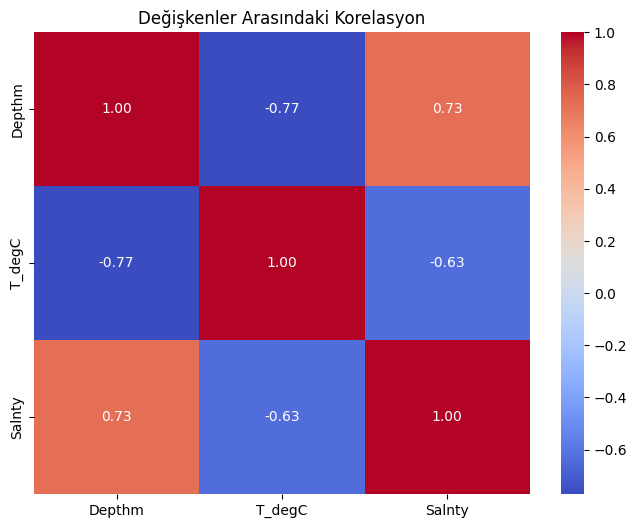

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['Depthm', 'T_degC', 'Salnty']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Değişkenler Arasındaki Korelasyon")
plt.show()

# Veri Noktaları İle Analiz

İki eksende verilerimizin dağılımlarını görmek için scatterplot kullanımı

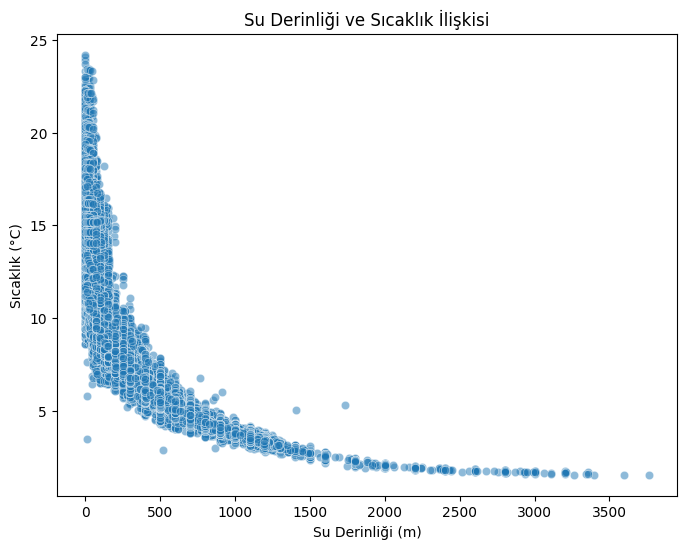

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['Depthm'], y=df['T_degC'], alpha=0.5)
plt.xlabel("Su Derinliği (m)")
plt.ylabel("Sıcaklık (°C)")
plt.title("Su Derinliği ve Sıcaklık İlişkisi")
plt.show()

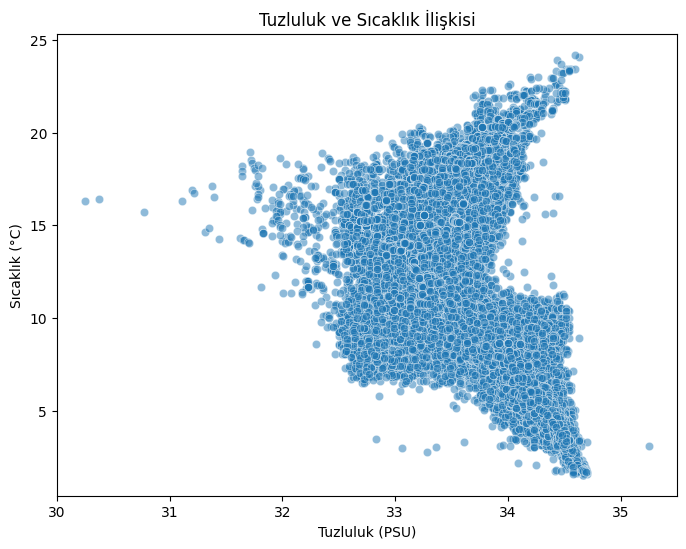

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['Salnty'], y=df['T_degC'], alpha=0.5)
plt.xlabel("Tuzluluk (Practical Salinity Unit)")
plt.ylabel("Sıcaklık (°C)")
plt.title("Tuzluluk ve Sıcaklık İlişkisi")
plt.show()

# psu 0 saf su

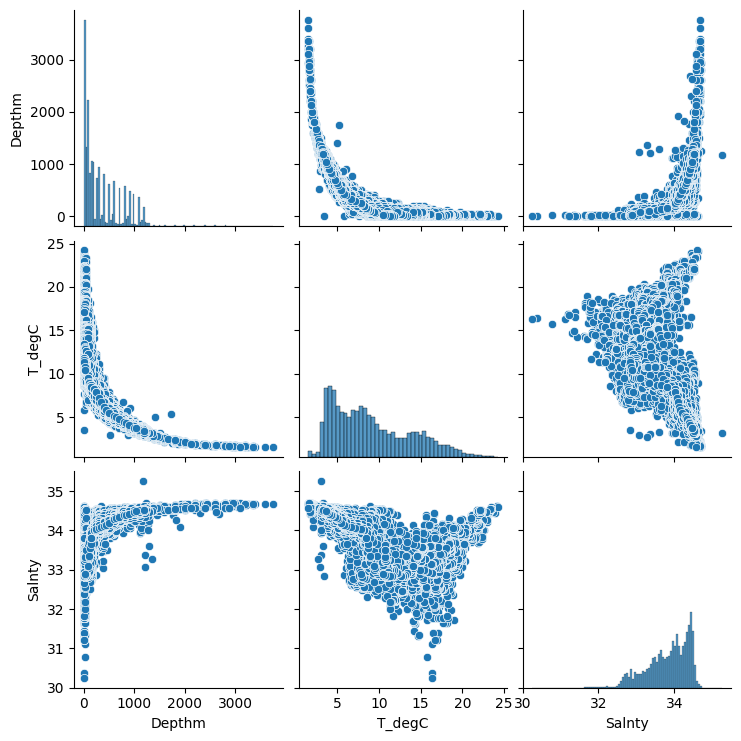

In [ ]:
#Farklı grafikleri hızlı hızlı göstermek
sns.pairplot(df[['Depthm', 'T_degC', 'Salnty']])
plt.show()

# Bir Regresyon modeli oluşturmak

Amacımız verilen girdilere bağlı bir çıktı tahmin etmek, mesela su tuzluluğu ve deinliğe bağlı olarak su sıcaklığı oranı nedir?

In [ ]:
# Girdi ve çıktı değişkenlerini tanımla
X = df[['Depthm', 'Salnty']]
y = df['T_degC']

Veriyi eğitim ve test seti için ayır

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Veriyi ölçekleyelim, burada amaç küçük tuzluluk değişimi olan (mesela 30 33 psu) bir aralıkta sayısal olarak derinlik değişimi çok olabilir.Bu boyut farkı (scale) modeli olumsuz etkiler amacımız aralıkların etkisini bir birine yaklaştırmak.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

farklı model kullanacak ve kıyaslacağız bunlar için modellerden oluşan bir dict yapısı kullandık

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100),
    "SVR": SVR(kernel='rbf', C=1)
}


Modelleri Eğit

In [ ]:
results = {}
for name, model in models.items():

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Performans ölçümleri
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "R²": r2}

R² (Determination Coefficient): Modelin ne kadar iyi tahmin yaptığını gösterir. 1'e yakınsa iyi bir modeldir.   
RMSE: Hata oranlarını gösterir. Düşük olmalıdır.

Sonuçları görelim

Linear Regression: RMSE = 2.86, R² = 0.61
Random Forest Regressor: RMSE = 1.68, R² = 0.86
SVR: RMSE = 1.56, R² = 0.88

🏅 En iyi model: SVR


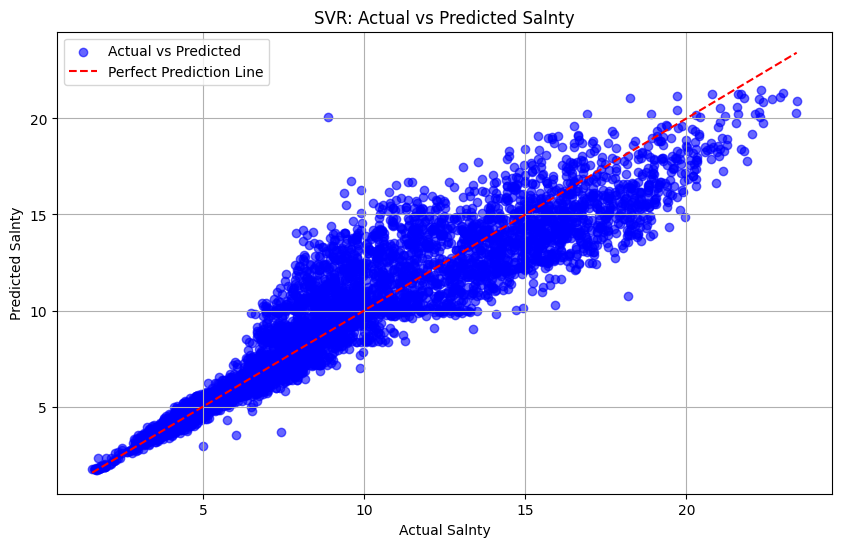

In [ ]:
# Sonuçları göster
for model, metrics in results.items():
    print(f"{model}: RMSE = {metrics['RMSE']:.2f}, R² = {metrics['R²']:.2f}")

# En iyi modeli seçip görselleştirelim
best_model = max(results, key=lambda x: results[x]['R²'])
print(f"\n🏅 En iyi model: {best_model}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Salnty')
plt.ylabel('Predicted Salnty')
plt.legend()
plt.title(f'{best_model}: Actual vs Predicted Salnty')
plt.grid(True)
plt.show()
